# Different Options For Bringing Images Into Your Notebook

## Introduction
[Two tutorials](https://notebooks.geobigdata.io/hub/notebooks/5b1d8d2e03cc425f56bc54d3) back we saw how to bring a satellite image into our notebook. Now we are going to dive in a bit more on *CatalogImage* and related image classes. Along the way we will learn some more about remote sensing.



## Underneath the Image

If we look at one band in a digital image, it is actually stored as a 2-dimensional array of numbers. Those number reflect the amount of reflectance captured on the sensor for that band. For satellite images, if we have an 8 band image, then we would have 8  2-D arrays of reflectance values. This image should help you visualize what I am talking about:

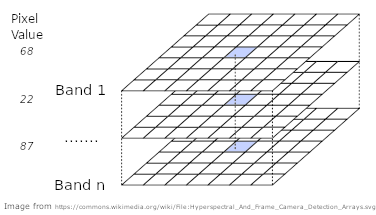

Python is really great at working with arrays of numbers, and Numpy is a (if not _the_) fundamental library for mathematical operations with arrays. The [CatalogImage](http://gbdxtools.readthedocs.io/en/latest/api_reference.html#catalogimage) that we are working with is a multi-dimensional array implemented in [Dask](https://dask.pydata.org/en/latest/) (a scalable version of [Numpy](http://www.numpy.org/)). In [the next tutorial](https://notebooks.geobigdata.io/hub/notebooks/5b623b832486966ea89b7e4e) we will dive more into working with the underlying arrays but for now let's stick to images. 

[Matplotlib](https://matplotlib.org/) is very powerful and popular Python package that knows how to render 2D arrays as images. If you are already familiar with Matplotlib then you should feel right at home since we use it under the covers for all our plotting. Unfortunately, if you are not familiar with Matplotlib the learning curve is pretty steep. 

We have done some work to avoid using Matplotlib directly In the previous code we call image.plot(). Well CatalogImage.plot() is a wrapper around a bunch of Matplotlib commands to make it easy to draw a simple image. At the current time if you want more advanced graphics you are going to have to dig into Matplotlib. 

Here is a [great tutorial](https://matplotlib.org/tutorials/introductory/images.html) on working with images in Matplotlib. Please note that to get the bands from the CatalogImage as numpy arrays you need to call 

```
image.rgb(bands=[4,2,1]))
```

where \[x,y,z\] are the satellite band indices you want to plot together. X will be drawn as red, y will be drawn as green, and z will be draw as blue.

Now let's go see how else we can alter the image we get back from the server. 

## Raw Image From the Satellite

By default when we bring in the CatalogImage, there has already been some processing done to the image. Since the satellite is in orbit, there is the whole atmosphere between the light reflected off the earth and the photons reaching the satellite. The atmosphere is full of particles and vapor that gets in the way. While we can not remove clouds, we can use general models based on the camera, haze, temperature, and other factors to remove some of these "artifacts". This process is called *atmospheric compensation* ( often shortened as acomp or acomped). 

### Whether or not to use acomped images is a topic of debate. 
1. It changes the original pixel values, therefore the same raw image could end up with different pixel values if two different models are used
2. Some groups use custom models per image (rather than a standard model across all images), leading to issues with reproducibility or broad scale application of the algorithm. 
3. Some analysts believe that the correction of atmospheric distortion is key to having an image that is "analysis ready"

Regardless of the current debate, let's go ahead and take a look at a satellite image before and after acomp.

In [1]:
from gbdxtools.task import env
from gbdxtools import CatalogImage
import matplotlib.pyplot as plt

catalog_id = env.inputs.get('catalog_id', '103001007FA2A200')
bbox = env.inputs.get('bbox', '-122.47249603271486, 37.77125750792944, -122.41928100585939, 37.816022261402544')

before_acomp = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
after_acomp = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")), acomp=True)

Text(0.5, 1.0, 'After')

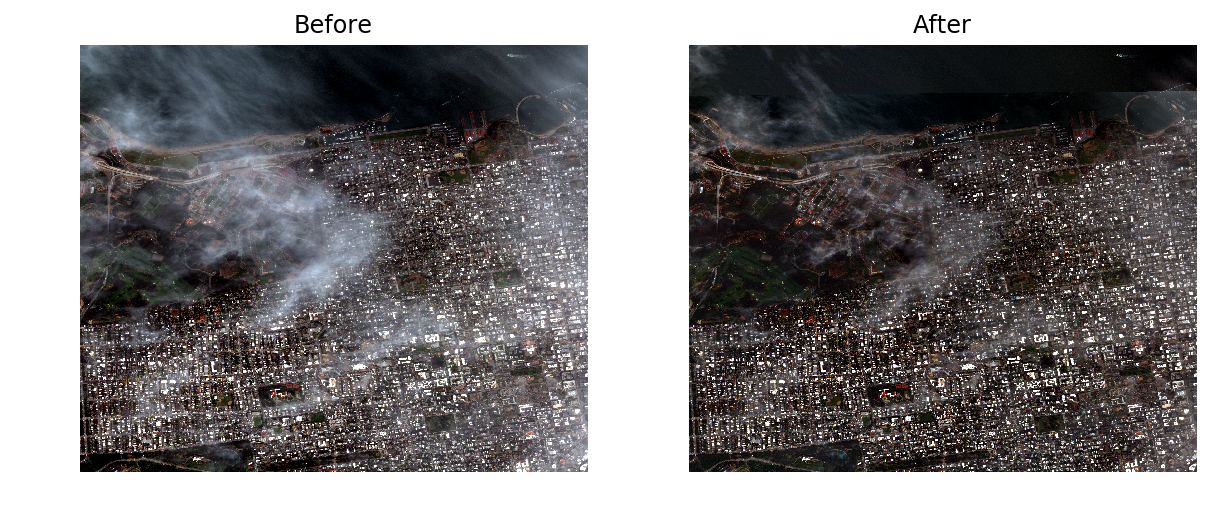

In [2]:
#make a figure that has 20 width and 10 height
fig = plt.figure(dpi=144,figsize=(10, 5))
a = fig.add_subplot(1, 2,1)
a.axis('off')
imgplot = plt.imshow(before_acomp.rgb(bands=[4,2,1]))
a.set_title('Before')
a = fig.add_subplot(1, 2, 2)
a.axis('off')
imgplot = plt.imshow(after_acomp.rgb(bands=[4,2,1]))
a.set_title('After')


The topic of how to correctly carry out atmospheric correction or compensation is a field of study unto itself with a [long history](http://www.mdpi.com/journal/remotesensing/special_issues/atmospheric_correction). Whether or not to acomp your images should probably be decided systematically for your research. Make sure you trust the acomp model used. 

## Next Question - Are You Doing Manual Visual Analysis or Algorithmic Analysis?

Now that we have correct for atmosphere effects, we face a big decision - do we want to make our image optimal for the human eye or do we want to run computer analysis on it. We face this decision because, some steps, while making it easier for humans to interpret the image actually change the underlying pixels values. With computational analysis we want to keep the original values as close to the original as possible, allowing us to take advantage of the "natural" patterns in the data. Let's illustrate while talking about one of our image options.

### Pan Sharpening

As we have discussed earlier, satellites have multiple bands. On the Landsat8 platform there is a sensor (camera) to capture the panchromatic band, which is a single wide electromagnetic band that captures a large portion of the visible spectrum. A different sensor captures the multispectral bands, like a band for red. These sensors have different spatial resolutions; panchromatic at 15 meter and multispectral at 30 meter resolution. 

Pan sharpening is the process of "merging" the higher spatial resolution panchromatic image with the higher spectral resolution multispectral image to get enhanced spatial resolution in the multispectal image.  Or you can think of it the other way - pansharpening takes a greyscale high resolution image and “colors” it with the multispectral data.

Text(0.5, 1.0, 'With Pan Sharpening')

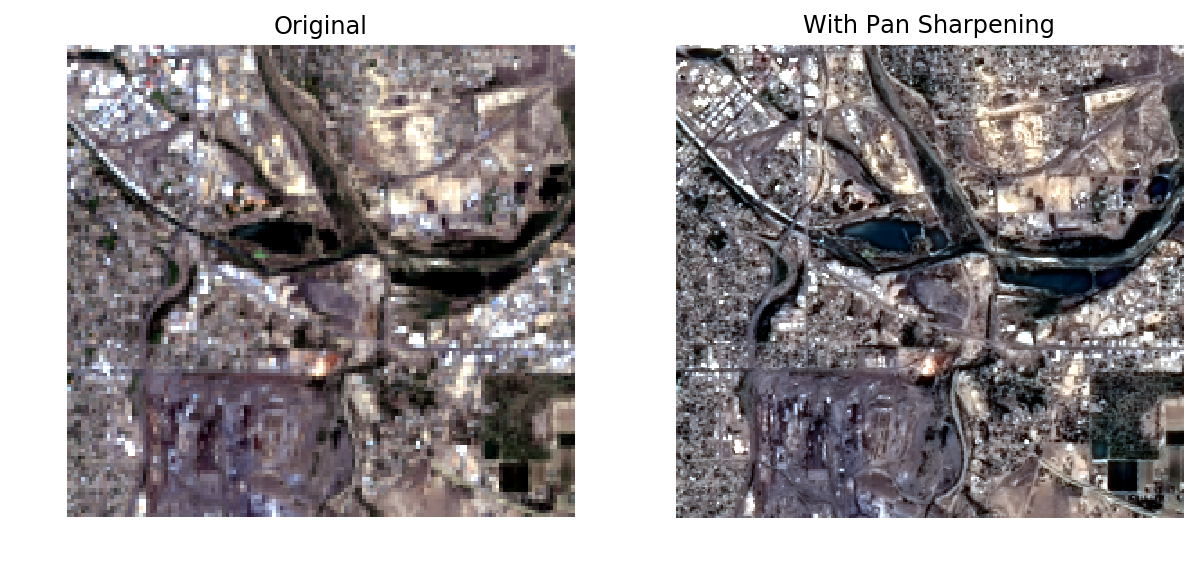

In [3]:
catalog_id = env.inputs.get('catalog_id', 'LC80330342018171LGN00')
bbox = env.inputs.get('bbox', '-104.61885452270509, 38.23292153989248, -104.57078933715822, 38.26824110558528')

without_pansharpen = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
with_pansharpen = CatalogImage(catalog_id, band_type="MS", pansharpen=True, bbox=map(float, bbox.split(",")))

#make a figure that has 20 width and 10 height
fig = plt.figure(dpi=144,figsize=(10, 5))
a = fig.add_subplot(1, 2,1)
a.axis('off')
imgplot = plt.imshow(without_pansharpen.rgb(bands=[3,2,1]))
a.set_title('Original')
a = fig.add_subplot(1, 2, 2)
a.axis('off')
imgplot = plt.imshow(with_pansharpen.rgb(bands=[3,2,1]))
a.set_title('With Pan Sharpening')

This looks great - multispectral data with better resolution - what's not to love? Well in the process of "merging" the images we ended up changing the actual pixel values in the multispectral image. If you are doing visual analysis this is not really a problem. If you are doing statistical analysis between the bands you might have a problem because you are altering the data, potentially throwing off the algorithm. As with acomp, be sure to carefully consider if pansharpening is necessary for your analysis. 

## Conclusion

And with that we are done talking about bringing images into your notebooks. We have just scratched the surface of loading imagery into notebooks. If you want to dig in more you can read some more of [the documentation](http://gbdxtools.readthedocs.io/en/latest/api_reference.html#catalogimage) on CatalogImage.  
You can also dig in to the following notebooks:
1. [Metadata Mining from images](https://notebooks.geobigdata.io/hub/notebooks/5a037c12f74cf64a53479966?tab=code)
2. [Bulk Image Calls](https://notebooks.geobigdata.io/hub/notebooks/5a6664f1aa91896cfe650571?tab=code)

You now have a good foundation on satellite images, how they are handled, and how to bring them into your workspace. Time to dig in on the fun stuff and start doing some analysis! Let's go to the next [tutorial notebook](https://notebooks.geobigdata.io/hub/notebooks/5b623b832486966ea89b7e4e).